# Downloading our VQA system

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from transformers import ViTModel, AutoModel, AutoModelForCausalLM, AutoTokenizer
from PIL import Image
import torch
import torch.nn as nn
from transformers import AutoModel, ViTModel, AutoModelForCausalLM
import urllib.request

from tqdm.auto import tqdm
import torch.nn.functional as F

import matplotlib.pyplot as plt
from transformers import ViTModel, ViTFeatureExtractor, AutoTokenizer, AutoModel, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
DECODER_MODEL = 'gpt2'
TEXT_ENCODER_MODEL = 'distilbert-base-uncased'
IMAGE_ENCODER_MODEL = "facebook/dino-vitb16"

In [ ]:
text_tokenizer = AutoTokenizer.from_pretrained(TEXT_ENCODER_MODEL)
decoder_tokenizer = AutoTokenizer.from_pretrained(DECODER_MODEL)
decoder_tokenizer.pad_token = decoder_tokenizer.eos_token
decoder_tokenizer.padding_side = "left"

image_feature_extractor = ViTFeatureExtractor.from_pretrained(IMAGE_ENCODER_MODEL)
image_feature_extractor.do_normalize = False  # controverisal pre-processing alteration

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
from PIL import Image

def retrieve_image(image_file):
    if 'http' in image_file:
        urllib.request.urlretrieve(image_file, "temp.jpg")
        image_file = 'temp.jpg'
    try:
        image = Image.open(image_file)
        return image
    except Exception as e:
        print(e)
        return None

def preprocess_image(image):
    # Open the image if the input is a file path
    if type(image) == str:
        img = Image.open(image)
    else:
        img = image
    return img.convert("RGB")

In [ ]:
class MultiModalModel(nn.Module):
    """
    A MultiModalModel class used to perform visual question answering (VQA).
    It consists of encoders for text and image and a decoder for generating the answer.

    Attributes:
        text_encoder: A model to encode text input.
        image_encoder: A model to encode image input.
        decoder: A model to decode and generate answers.
        text_projection: A linear layer to project text encoding to a specific size.
        image_projection: A linear layer to project image encoding to a specific size.
    """

    def __init__(self, text_encoder_model, image_encoder_model, decoder_model, freeze=None, load_from=None):
        super(MultiModalModel, self).__init__()

        # Initialize text and image encoders
        self.text_encoder = AutoModel.from_pretrained(text_encoder_model).to(device)
        self.image_encoder = ViTModel.from_pretrained(image_encoder_model).to(device)

        # Initialize the GPT-2 decoder
        self.decoder = AutoModelForCausalLM.from_pretrained(
            decoder_model,
            add_cross_attention=True,
            tie_word_embeddings=True
        ).to(device)

        # Initialize linear layers for projecting encoded features
        self.text_projection = nn.Linear(self.text_encoder.config.hidden_size, self.decoder.config.hidden_size).to(device)
        self.image_projection = nn.Linear(self.image_encoder.config.hidden_size, self.decoder.config.hidden_size).to(device)

        # Freeze specified encoders if required or load from a checkpoint
        if load_from:
            print(f"Loading model from {load_from}")
            self.load_model_checkpoint(load_from)
        else:
            self.freeze(freeze)

    def freeze(self, freeze):
        """
        Freeze specific parts of the model to prevent them from being updated during training.

        Parameters:
            freeze (str): Which parts to freeze. Can be 'encoders', 'decoder', 'all', or specific encoder.
        """
        if not freeze or freeze == 'nothing':
            return

        print('Freezing...')
        if freeze in ('encoders', 'all') or 'text_encoder' in freeze:
            print('Freezing text encoder')
            for param in self.text_encoder.parameters():
                param.requires_grad = False

        if freeze in ('encoders', 'all') or 'image_encoder' in freeze:
            print('Freezing image encoder')
            for param in self.image_encoder.parameters():
                param.requires_grad = False

        if freeze in ('decoder', 'all'):
            print('Freezing decoder (except for cross attention)')
            for name, param in self.decoder.named_parameters():
                if "crossattention" not in name:
                    param.requires_grad = False

    def load_model_checkpoint(self, path):
        """
        Load the model from a saved checkpoint.

        Parameters:
            path (str): Path to the saved checkpoint.
        """
        checkpoint = torch.load(path)
        checkpoint = {k.replace("module.", ""): v for k, v in checkpoint.items()}
        self.load_state_dict(checkpoint)

    def check_input(self, tensor, tensor_name):
        """
        Check if there are any NaN or infinite values in the input tensor.

        Parameters:
            tensor (torch.Tensor): Input tensor.
            tensor_name (str): Name of the tensor for error logging.
        """
        if torch.isnan(tensor).any() or torch.isinf(tensor).any():
            print(f"NaN or infinite values found in {tensor_name}")

    def encode_text(self, input_text, attention_mask):
        """
        Encode text using the text encoder and project it to a specific size.

        Parameters:
            input_text (torch.Tensor): Input text tensor.
            attention_mask (torch.Tensor): Attention mask for the input text.

        Returns:
            torch.Tensor: Projected text encoding.
        """
        self.check_input(input_text, "input_text")
        input_text = input_text.to(device)
        attention_mask = attention_mask.to(device)
        text_encoded = self.text_encoder(input_text, attention_mask=attention_mask).last_hidden_state.mean(dim=1).to(device)
        return self.text_projection(text_encoded)

    def encode_image(self, input_image):
        """
        Encode image using the image encoder and project it to a specific size.

        Parameters:
            input_image (torch.Tensor): Input image tensor.

        Returns:
            torch.Tensor: Projected image encoding.
        """
        self.check_input(input_image, "input_image")
        image_encoded = self.image_encoder(input_image).last_hidden_state.mean(dim=1)
        return self.image_projection(image_encoded)

    def forward(self, input_text, input_image, decoder_input_ids, attention_mask, labels=None):
        """
        Forward pass through the model.

        Parameters:
            input_text (torch.Tensor): Input text tensor.
            input_image (torch.Tensor): Input image tensor.
            decoder_input_ids (torch.Tensor): Decoder input IDs tensor.
            attention_mask (torch.Tensor): Attention mask for the input text.
            labels (torch.Tensor, optional): Ground truth labels for the target.

        Returns:
            torch.Tensor: Decoder output.
        """
        self.check_input(decoder_input_ids, "decoder_input_ids")

        # Encode text and image
        text_projected = self.encode_text(input_text, attention_mask)
        image_projected = self.encode_image(input_image)

        # Combine encoded features
        combined_features = (text_projected + image_projected) / 2

        # Decode with GPT-2
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            labels=labels,
            encoder_hidden_states=combined_features.unsqueeze(1)
        )
        return decoder_outputs

    def generate(self, image, questions, max_text_length=5, eos_token_id=None):
        """
        Generate answers for the given image and list of questions.

        Parameters:
            image (Image): Input image.
            questions (list): List of questions related to the image.
            max_text_length (int, optional): Maximum text length for generated answers.

        Returns:
            Image: Input image.
        """
        # Encode text and image
        image = retrieve_image(image)
        image_input = image_feature_extractor(images=[preprocess_image(image)], return_tensors="pt").to(device)
        input_image = image_input["pixel_values"].to(device)
        image_projected = self.encode_image(input_image).to(device)
        answers = {}

        for question in questions:
            i = text_tokenizer(question, return_tensors='pt')
            text_projected = self.encode_text(i['input_ids'], i['attention_mask'])

            # Combine encoded features
            combined_features = (text_projected + image_projected) / 2

            generated_so_far = torch.LongTensor([[decoder_tokenizer.bos_token_id]]).to(device)
            with torch.no_grad():
                for _ in tqdm(range(max_text_length)):

                    decoder_outputs = self.decoder(
                        input_ids=generated_so_far,
                        encoder_hidden_states=combined_features.unsqueeze(1)
                    )

                    next_token_logits = decoder_outputs.logits[:, -1, :]
                    next_token_probs = F.softmax(next_token_logits, dim=-1)
                    next_token = next_token_logits.argmax(-1)
                    confidence = next_token_probs[0, next_token].item()
                    print("Next token:", decoder_tokenizer.decode(next_token), "Confidence:", confidence)
                    second_best_token = next_token_logits.argsort(-1)[0, 1]
                    second_best_confidence = next_token_probs[0, second_best_token].item()
                    print("\tSecond best token:", decoder_tokenizer.decode(second_best_token), "Confidence:", second_best_confidence)
                    generated_so_far = torch.cat((generated_so_far, next_token.unsqueeze(0)), dim=1)
                    if eos_token_id is not None and next_token.item() == eos_token_id:
                        break
            answers[question] = decoder_tokenizer.decode(generated_so_far[0])

        return image, answers


In [ ]:
from huggingface_hub import HfFolder, notebook_login
notebook_login()

In [ ]:
!git lfs install

!git clone https://huggingface.co/profoz/quick-start-llm-vqa

!cp /content/vqa_custom/pytorch_model.bin /content/quick-start-llm-vqa/
!cp /content/vqa_custom/training_args.bin /content/quick-start-llm-vqa/


Git LFS initialized.
Cloning into 'quick-start-llm-vqa'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (11/11), 2.12 KiB | 1.06 MiB/s, done.
cp: cannot stat '/content/vqa_custom/pytorch_model.bin': No such file or directory
cp: cannot stat '/content/vqa_custom/training_args.bin': No such file or directory


In [ ]:
trained_model = MultiModalModel(
    image_encoder_model=IMAGE_ENCODER_MODEL, text_encoder_model=TEXT_ENCODER_MODEL,
    decoder_model=DECODER_MODEL, load_from="quick-start-llm-vqa/pytorch_model.bin")

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.

Loading model from quick-start-llm-vqa/pytorch_model.bin


# Using our VQA system

  0%|          | 0/5 [00:00<?, ?it/s]

Next token: ten Confidence: 0.9745339751243591
	Second best token:  conclud Confidence: 3.995558195690742e-32
Next token: nis Confidence: 1.0
	Second best token: ModLoader Confidence: 2.9567808173667948e-33
Next token: <|endoftext|> Confidence: 0.999915599822998
	Second best token: lished Confidence: 3.3846156024598034e-25


  0%|          | 0/5 [00:00<?, ?it/s]

Next token: white Confidence: 0.629950761795044
	Second best token:  exha Confidence: 6.014655706434321e-31
Next token: <|endoftext|> Confidence: 0.997787356376648
	Second best token:  tremend Confidence: 2.565999873332891e-18


  0%|          | 0/5 [00:00<?, ?it/s]

Next token: white Confidence: 0.43503662943840027
	Second best token:  millenn Confidence: 1.8589283735115482e-35
Next token: <|endoftext|> Confidence: 0.9949032068252563
	Second best token: 覚醒 Confidence: 3.7786668590995004e-21

what sport is this person playing?: tennis
what color are the words on the ground?: white
what color is the ground overall?: white


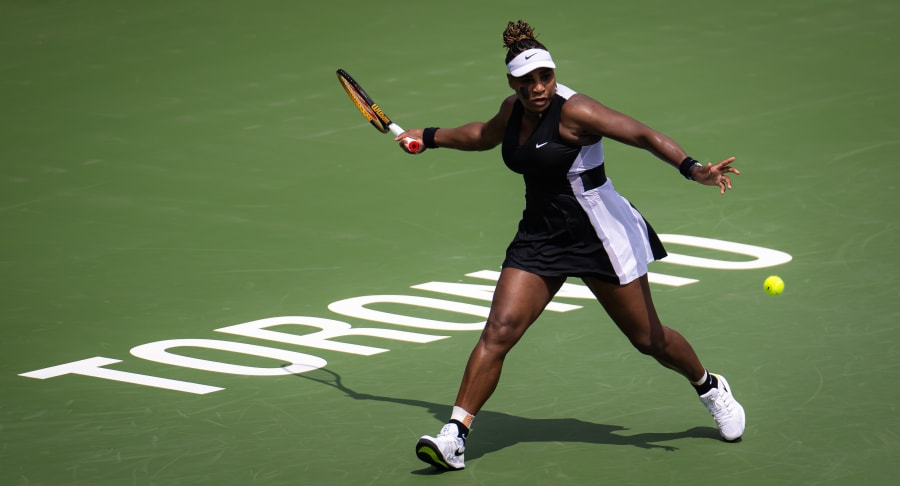

In [ ]:
url = 'https://res.cloudinary.com/graham-media-group/image/upload/f_auto/q_auto/c_scale,w_900/v1/media/gmg/UGVGRTQSUJDITNE5KNT4L3VAK4.jpg?_a=AJFJtWIA'

image, answers = trained_model.generate(
    url,
     [
         'what sport is this person playing?',
         'what color are the words on the ground?',
         'what color is the ground overall?'
         ], max_text_length=5,
    eos_token_id=decoder_tokenizer.eos_token_id)
print()
for question, answer in answers.items():
    print(f'{question}: {answer.replace(decoder_tokenizer.eos_token, "")}')
image

  0%|          | 0/5 [00:00<?, ?it/s]

Next token: g Confidence: 0.6632120609283447
	Second best token:  behavi Confidence: 1.553964593536693e-32
Next token: ir Confidence: 0.9995566010475159
	Second best token: etheless Confidence: 1.6844072914691223e-32
Next token: affe Confidence: 0.9999996423721313
	Second best token: WARE Confidence: 4.862588961697342e-34
Next token: <|endoftext|> Confidence: 0.9999997615814209
	Second best token: soDeliveryDate Confidence: 1.2459373329870652e-27


  0%|          | 0/5 [00:00<?, ?it/s]

Next token: no Confidence: 0.5050703883171082
	Second best token:  metic Confidence: 5.300595579562892e-21
Next token: <|endoftext|> Confidence: 1.0
	Second best token: DonaldTrump Confidence: 1.9616169640335447e-26


  0%|          | 0/5 [00:00<?, ?it/s]

Next token: yes Confidence: 0.6736500859260559
	Second best token:  metic Confidence: 1.460271856982297e-21
Next token: <|endoftext|> Confidence: 1.0
	Second best token: paralle Confidence: 3.512212513432061e-27

what animal is this?: giraffe
is this inside?: no
is this outside?: yes


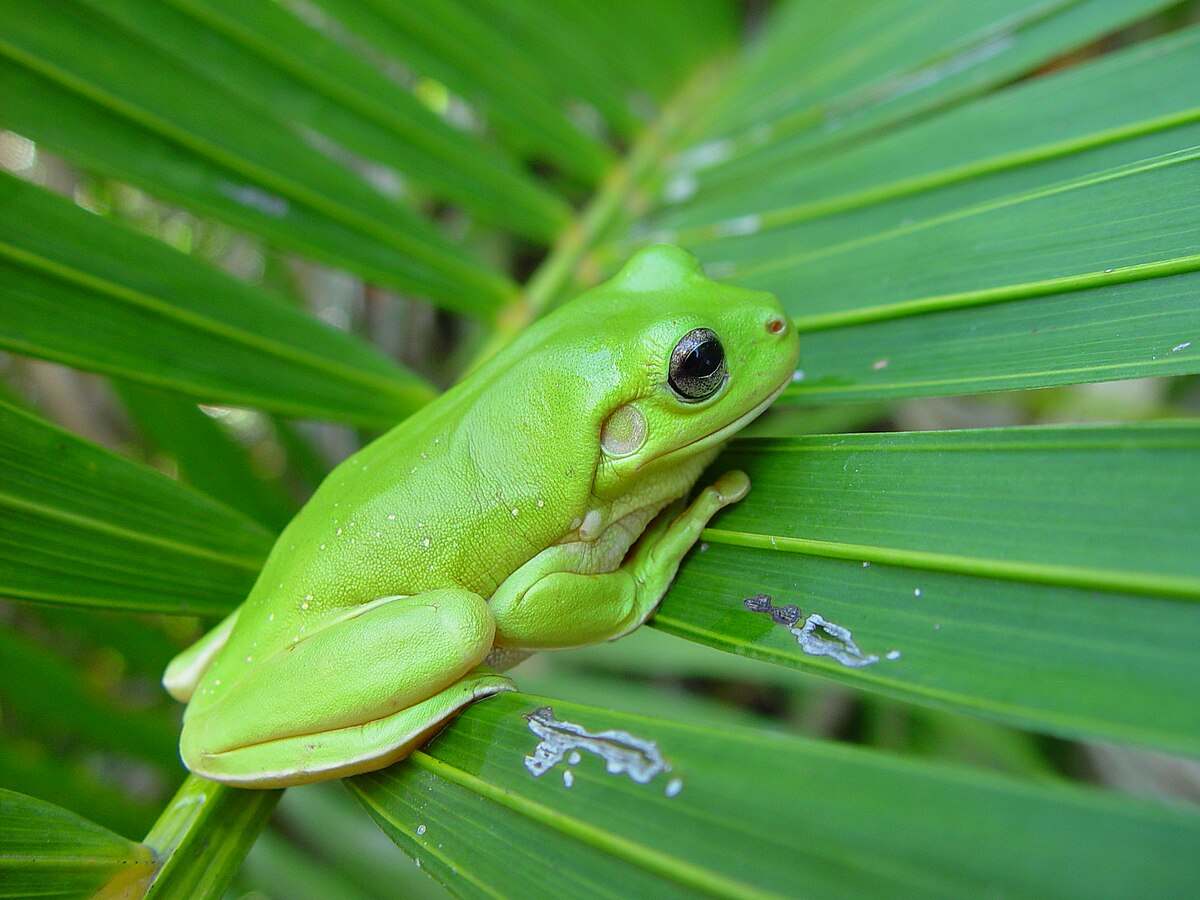

In [ ]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Frog_on_palm_frond.jpg/1200px-Frog_on_palm_frond.jpg'

image, answers = trained_model.generate(
    url,
     [
         'what animal is this?', 'is this inside?', 'is this outside?'
         ], max_text_length=5,
    eos_token_id=decoder_tokenizer.eos_token_id)
print()
for question, answer in answers.items():
    print(f'{question}: {answer.replace(decoder_tokenizer.eos_token, "")}')
image

  0%|          | 0/5 [00:00<?, ?it/s]

Next token: red Confidence: 0.7055313587188721
	Second best token: � Confidence: 2.862812709382436e-29
Next token: <|endoftext|> Confidence: 0.9947569370269775
	Second best token:  Citiz Confidence: 3.484320292677474e-20

What color is this bus?: red


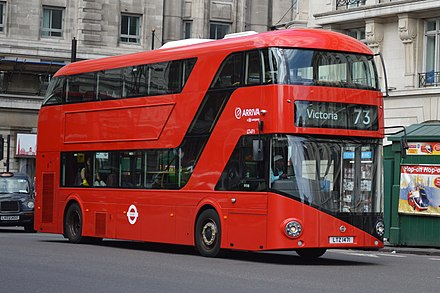

In [ ]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/LT_471_%28LTZ_1471%29_Arriva_London_New_Routemaster_%2819522859218%29.jpg/440px-LT_471_%28LTZ_1471%29_Arriva_London_New_Routemaster_%2819522859218%29.jpg'

image, answers = trained_model.generate(
    url,
     [
         'What color is this bus?'
         ], max_text_length=5,
    eos_token_id=decoder_tokenizer.eos_token_id)
print()
for question, answer in answers.items():
    print(f'{question}: {answer.replace(decoder_tokenizer.eos_token, "")}')
image

  0%|          | 0/5 [00:00<?, ?it/s]

Next token: red Confidence: 0.9076421856880188
	Second best token: � Confidence: 2.2281549962774338e-30
Next token: <|endoftext|> Confidence: 0.884543240070343
	Second best token: ITNESS Confidence: 6.732243610773745e-19


  0%|          | 0/5 [00:00<?, ?it/s]

Next token: stop Confidence: 0.0372682586312294
	Second best token:  exha Confidence: 7.733679148469452e-14
Next token: <|endoftext|> Confidence: 0.9159228801727295
	Second best token:  Pry Confidence: 2.457906230298899e-15


  0%|          | 0/5 [00:00<?, ?it/s]

Next token: stop Confidence: 0.08705193549394608
	Second best token:  exha Confidence: 1.892005847578906e-15
Next token: <|endoftext|> Confidence: 0.9884004592895508
	Second best token: Sov Confidence: 1.3718597229800872e-16

What color is this sign?: red
What does the sign say?: stop
What is the sign?: stop


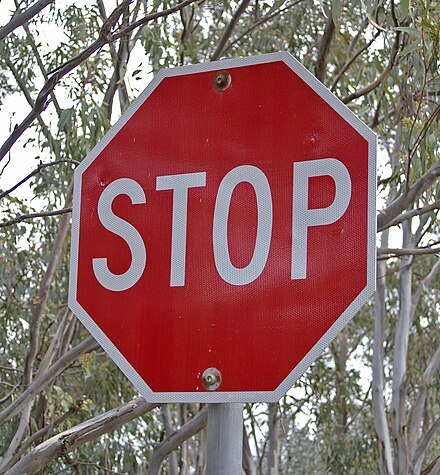

In [ ]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/STOP_sign.jpg/440px-STOP_sign.jpg'

image, answers = trained_model.generate(
    url,
     [
         'What color is this sign?', 'What does the sign say?', 'What is the sign?'
         ], max_text_length=5,
    eos_token_id=decoder_tokenizer.eos_token_id)
print()
for question, answer in answers.items():
    print(f'{question}: {answer.replace(decoder_tokenizer.eos_token, "")}')
image

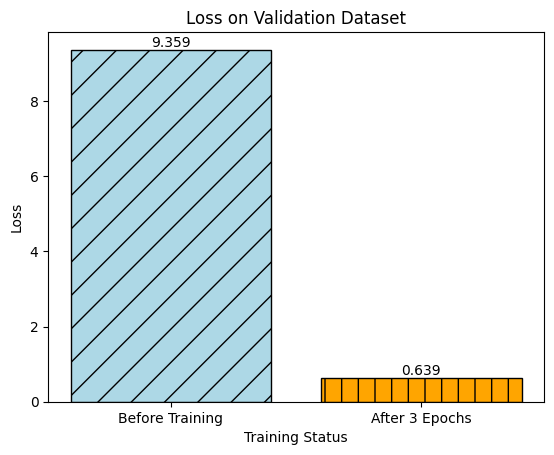

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Before Training', 'After 3 Epochs']
loss_values = [9.359, 0.639]
colors = ['lightblue', 'orange']
hatches = ['/', '|']

# Plot
fig, ax = plt.subplots()

bars = ax.bar(categories, loss_values, color=colors, edgecolor='black', hatch=hatches)

# Add labels
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')  # ha: horizontal alignment, va: vertical alignment

ax.set_title('Loss on Validation Dataset')
ax.set_ylabel('Loss')
ax.set_xlabel('Training Status')

# Save the figure with high resolution
plt.savefig('loss_validation_dataset.png', dpi=1000)

plt.show()


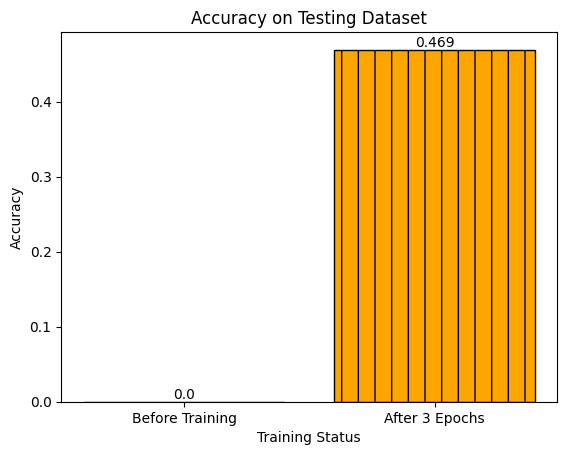

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Before Training', 'After 3 Epochs']
loss_values = [0, 0.469352]
colors = ['lightblue', 'orange']
hatches = ['/', '|']

# Plot
fig, ax = plt.subplots()

bars = ax.bar(categories, loss_values, color=colors, edgecolor='black', hatch=hatches)

# Add labels
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')  # ha: horizontal alignment, va: vertical alignment

ax.set_title('Accuracy on Testing Dataset')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Training Status')

# Save the figure with high resolution
plt.savefig('accuracy_test_dataset.png', dpi=1000)

plt.show()
